In [1]:
from dolfin import *
import numpy as np

Consider the following flow

$$
u(x, y, z) = \begin{pmatrix}xz-2cy/(x^2 + y^2+\epsilon) \\
yz +2cx/(x^2 + y^2+\epsilon) \\
1-2(x^2 + y^2)-z^2\end{pmatrix}
$$
In cylindrical coordinates the flow is given by
$$
\frac{dr}{dt}=rz\\
\frac{dz}{dt}=1-2r^2-z^2\\
\frac{d\theta}{dt}=\frac{2c}{r^2+\epsilon}
$$
where $c$ is an arbitrary constant. In a fluid-mechanical context, $c/2$ is the circulation. The flow above is a superposition of a well-known Hill's spherical vortex with a line vortex on the $z$ axis, which induces a swirl velocity $\dot{\theta}$. The system of equations satisfies Euler's equations of motion for an inviscid imcompressible fluid everywhere except on the $z$ axis, where the swirl velocity becomes infinite. Note that we add $\epsilon$ to avoid singularity.

For spherical vortex, we have
$$
\frac{dr}{dt}=rz\\
\frac{dz}{dt}=1-2r^2-z^2\\
\frac{d\theta}{dt}=0.
$$
So we can set $c=0$ to recover the spherical vortex

The stream function for spherical vortex is given as below 
$$
\psi(r,z) = \frac{1}{2} r^2(1-z^2-r^2)
$$

We have
$$
\frac{d\psi}{dt}=\nabla\psi\cdot\mathbf{u} = \frac{\partial\psi}{\partial z}\dot{z}+\frac{\partial\psi}{\partial r}\dot{r}=-r^2z(1-2r^2-z^2)+r(1-z^2-2r^2)rz\equiv0.
$$
It follows that $\psi(r,z)$ is a first integral, independently of $c$. In the following computation, we set $c=0.1$

In [2]:
def eigenvalues(X, V):
#
    # Define the bilinear forms on the right- and left-hand sides
    H = TrialFunction(V)
    h = TestFunction(V)
    a = (inner(X,grad(H))*inner(X, grad(h)))*dx #+inner(H,h)*dx - shift zero eigenvalue
    b = inner(H,h)*dx
#
    # Assemble into PETSc matrices
    A = PETScMatrix()
    assemble(a, tensor=A)
    B = PETScMatrix()
    assemble(b, tensor=B)
#
    solver = SLEPcEigenSolver(A, B)
    solver.parameters["solver"] = "krylov-schur" # "lapack" # "lanczos" # "krylov-schur" - not good for high-fidelty discretization
    solver.parameters["problem_type"] = "gen_hermitian"
    #solver.parameters["maximum_iterations"] = 10000
    #solver.parameters['tolerance'] = 1.e-14
    solver.parameters["spectrum"] = "target magnitude"
    solver.parameters["spectral_transform"] = "shift-and-invert"
    solver.parameters["spectral_shift"] = -0.1 # 0 is not working, 1e-14 or negative number (-0.1) works fine
    
    neigs = 4
    solver.solve(neigs)
    # print("number of iterations is ",solver.get_iteration_number())
    print("number of converged eigenvalues: ",solver.get_number_converged())
#
    # Return the computed eigenvalues in a sorted array
    computed_eigenvalues = []
    for i in range(min(neigs, solver.get_number_converged())):
        r, _ = solver.get_eigenvalue(i) # ignore the imaginary part
        computed_eigenvalues.append(r)
        print("eigenvalue: ", r)
    # Return the H corresponding to the first and second eigenvalue
    print("return the first eienvector")
    r, c, rx, cx = solver.get_eigenpair(0)
    # Turn the eigenvector into a Function:
    rx_func0 = Function(V)
    rx_func0.vector()[:] = rx
    print("return the second eienvector")
    r, c, rx, cx = solver.get_eigenpair(1)
    # Turn the eigenvector into a Function:
    rx_func1 = Function(V)
    rx_func1.vector()[:] = rx
    print("return the third eienvector")
    r, c, rx, cx = solver.get_eigenpair(1)
    # Turn the eigenvector into a Function:
    rx_func2 = Function(V)
    rx_func2.vector()[:] = rx
    
    return np.array(computed_eigenvalues), rx_func0, rx_func1, rx_func2


In [3]:
def objective(X,H,V):
    x0 = project(X[0],V,solver_type='iterative')
    x1 = project(X[1],V,solver_type='iterative')
    x2 = project(X[2],V,solver_type='iterative')
    gh = grad(H)
    err_grand = x0*gh[0]+x1*gh[1]+x2*gh[2] 
    res = (err_grand*err_grand)*dx
    res = np.sqrt(assemble(res))
    print('residual in L2 norm is',res)
    return res


In [4]:
def plot_results(rhosamp,thetasamp,psisamp,dirname,H1,Href,mode):
    from matplotlib import pyplot as plt
    nrho = np.size(rhosamp)
    nth  = np.size(thetasamp)
    npsi = np.size(psisamp)
    RHO,TH=np.meshgrid(rhosamp,thetasamp)
    yy = RHO*np.sin(TH)
    zz = RHO*np.cos(TH)
    hx = H1[:,:,np.argmin(abs(psisamp-0.5*pi))]
    hx = np.reshape(hx,[nrho,nth])
    plt.figure()
    plt.contour(yy,zz,hx.T,100)
    plt.colorbar()  
    plt.title('x=0 (FEniCS)')
    plt.savefig(dirname+'/xFEM.eps',format='eps')
    href = Href[:,:,np.argmin(abs(psisamp-0.5*pi))]
    href = np.reshape(href,[nrho,nth])
    plt.figure()
    plt.contour(yy,zz,href.T,100)
    plt.colorbar()   
    plt.title('x=0 (Reference)')
    plt.savefig(dirname+'/xref.eps',format='eps')    

    
    xx = RHO*np.sin(TH)
    zz = RHO*np.cos(TH)
    hx = H1[:,:,np.argmin(abs(psisamp-0))]
    hx = np.reshape(hx,[nrho,nth])
    plt.figure()
    plt.contour(xx,zz,hx.T,100)
    plt.colorbar()   
    plt.title('y=0 (FEniCS)')
    plt.savefig(dirname+'/yFEM.eps',format='eps')
    href = Href[:,:,np.argmin(abs(psisamp-0))]
    href = np.reshape(href,[nrho,nth])
    plt.figure()
    plt.contour(xx,zz,href.T,100)
    plt.colorbar()   
    plt.title('y=0 (Reference)')
    plt.savefig(dirname+'/yref.eps',format='eps') 
    
    hz = H1[:,np.argmin(abs(thetasamp-0.5*pi)),:];
    hz = np.reshape(hz,[nrho,npsi])
    RHO,PSI=np.meshgrid(rhosamp,psisamp)
    xx = RHO*np.cos(PSI)
    yy = RHO*np.sin(PSI)
    plt.figure();
    plt.contour(xx,yy,hz.T,100)
    plt.colorbar()
    plt.title('z=0 (FEniCS)')
    plt.savefig(dirname+'/zFEM.eps',format='eps')
    hzref = Href[:,np.argmin(abs(thetasamp-0.5*pi)),:];
    hzref = np.reshape(hzref,[nrho,npsi])
    plt.figure();
    plt.contour(xx,yy,hzref.T,100)
    plt.colorbar()
    plt.title('z=0 (Reference)')
    plt.savefig(dirname+'/zref.eps',format='eps')

In [5]:
def print_eigenvalues_save_solutions(X,mesh,order,ngrids,rhosamp,thetasamp,psisamp,coef):
#
    # V = FunctionSpace(mesh, "Lagrange", order, constrained_domain=pbc)
    V = FunctionSpace(mesh, "Lagrange", order)
    lamd,eiv0,eiv1,eiv2 = eigenvalues(X,V)
    np.set_printoptions(formatter={'float': '{:5.2f}'.format})
    print("Eigenvales:  {}".format(lamd))
#
    # demonstrate the first eigensolution corresponds to constant solution
    print("The first eigensolution is expected to be constant")
    nrho = np.size(rhosamp)
    nth  = np.size(thetasamp)
    npsi = np.size(psisamp)
    H0 = np.zeros((nrho,nth,npsi))
    for i in range(nrho):
        for j in range(nth):
            for k in range(npsi):
                xp = rhosamp[i]*np.sin(thetasamp[j])*np.cos(psisamp[k])
                yp = rhosamp[i]*np.sin(thetasamp[j])*np.sin(psisamp[k])
                zp = rhosamp[i]*np.cos(thetasamp[j])
                H0[i,j,k] = eiv0(xp,yp,zp)
    h0 = H0.flatten()
    dh0 = max(h0)-min(h0)
    print("range of H0: ", dh0)
#
    # plot of the second eigensolution and save solution
    print("Plot and store the second eigensolution")
    H1 = np.zeros((nrho,nth,npsi))
    H2 = np.zeros((nrho,nth,npsi))
    Href = np.zeros((nrho,nth,npsi))
    for i in range(nrho):
        for j in range(nth):
            for k in range(npsi):
                xp = rhosamp[i]*np.sin(thetasamp[j])*np.cos(psisamp[k])
                yp = rhosamp[i]*np.sin(thetasamp[j])*np.sin(psisamp[k])
                zp = rhosamp[i]*np.cos(thetasamp[j])                
                H1[i,j,k] = eiv1(xp,yp,zp)
                H2[i,j,k] = eiv2(xp,yp,zp)
                rsquare = xp*xp+yp*yp
                Href[i,j,k] = 0.5*rsquare*(1-zp*zp-rsquare)
    h1 = H1.flatten()
    dh1 = max(h1)-min(h1)
    print("range of H1: ", dh1)
    import os
    dirname = 'SphereDomain'+'ngrids'+str(ngrids)+'order'+str(order)+'c'+coef
    isFile = os.path.isdir(dirname) 
    if not isFile:
        os.mkdir(dirname)
#
    # contour plot of H at sections x=0, y=0 and z=0
    plot_results(rhosamp,thetasamp,psisamp,dirname,H1,Href,1)
    # plot_results(rhosamp,thetasamp,psisamp,dirname,H2,Href,2)
    # res = objective(X,eiv1,V)
#    
    # save solution as matlab compatible file
    mdic = {"rho": rhosamp, "theta": thetasamp, "psi": psisamp, "lambda": lamd, "H": H1, "Href": Href,"numDOF": V.dim(),"numEle": mesh.num_cells()}
    from scipy.io import savemat
    savemat(dirname,mdic)
    

***************************************************
computation at order 2 and 10 grid points
number of converged eigenvalues:  6
eigenvalue:  -3.3306690738754696e-15
eigenvalue:  0.02324861499502323
eigenvalue:  0.23283743906198875
eigenvalue:  0.23436617253891975
return the first eienvector
return the second eienvector
return the third eienvector
Eigenvales:  [-0.00  0.02  0.23  0.23]
The first eigensolution is expected to be constant
range of H0:  4.51805259871e-13
Plot and store the second eigensolution
range of H1:  1.78509147042
***************************************************
computation at order 2 and 20 grid points
number of converged eigenvalues:  5
eigenvalue:  1.9594048605853231e-13
eigenvalue:  0.001489837150532372
eigenvalue:  0.06020129391876458
eigenvalue:  0.08057040910064381
return the first eienvector
return the second eienvector
return the third eienvector
Eigenvales:  [ 0.00  0.00  0.06  0.08]
The first eigensolution is expected to be constant
range of H0:  2.26

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:47: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`)

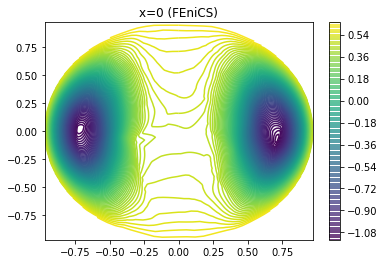

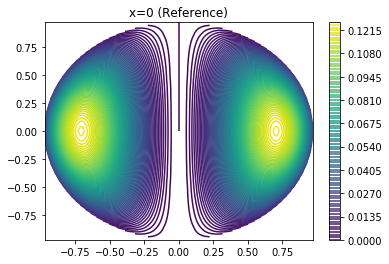

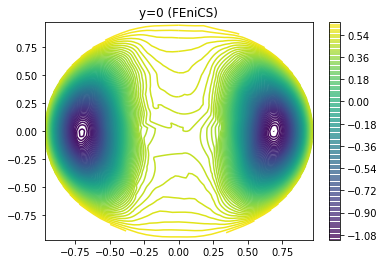

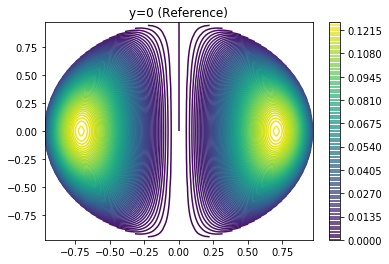

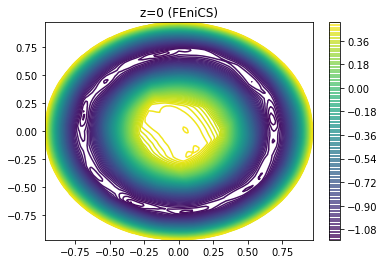

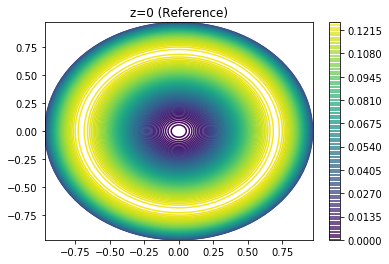

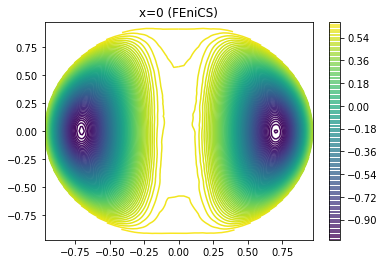

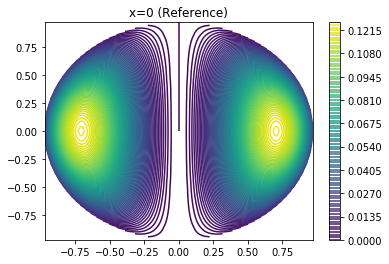

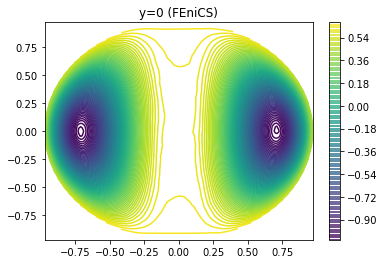

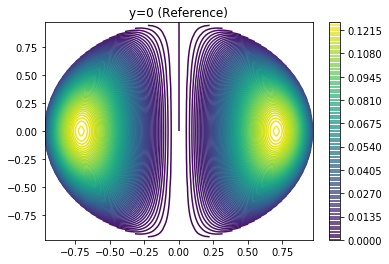

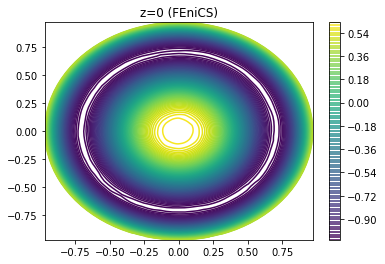

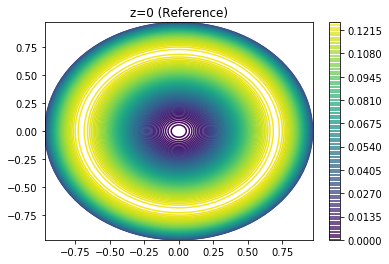

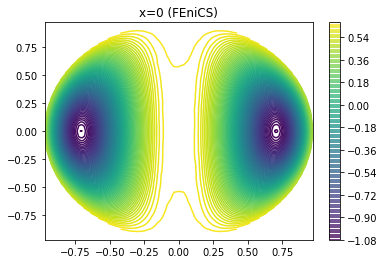

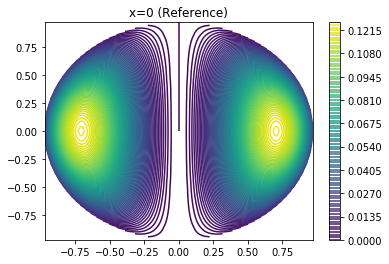

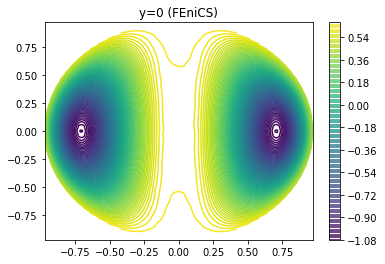

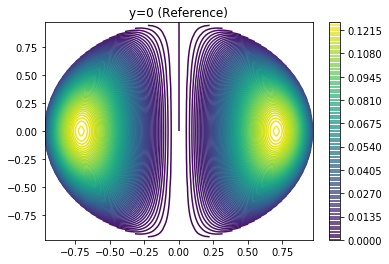

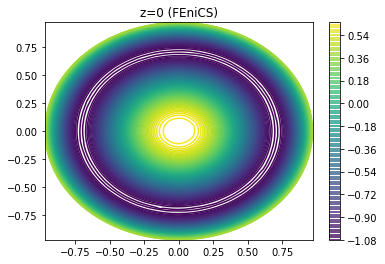

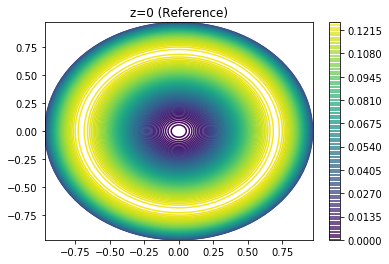

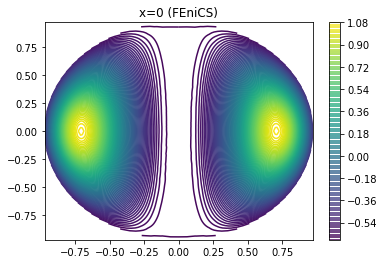

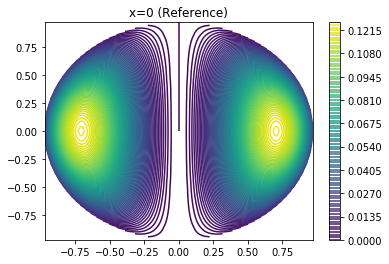

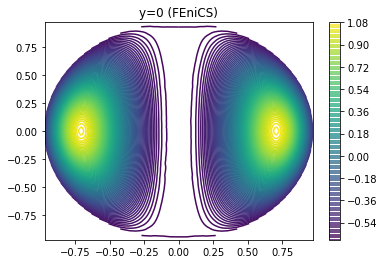

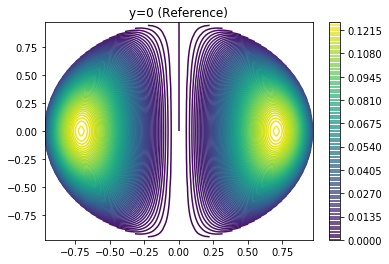

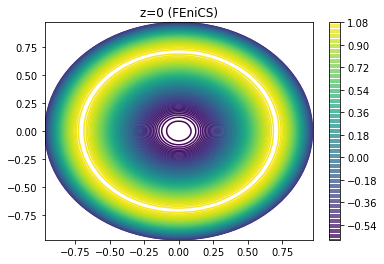

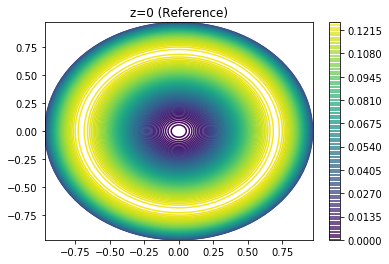

In [6]:
# set up problem
from mshr import *
order = 2
numGrids = np.array([10,20,30,40])
a = 1.0
rhosamp   = np.linspace(0,0.97,80) # evaluation of H for plotting
thetasamp = np.linspace(0,2*pi,101) 
psisamp   = np.linspace(0,2*pi,101) 
sphere    = Sphere(Point(0,0,0),1)
coef = '0p1'
x1 = 'x[0]*x[2]-2*0.1*x[1]/(x[0]*x[0]+x[1]*x[1]+0.1)'
x2 = 'x[1]*x[2]+2*0.1*x[0]/(x[0]*x[0]+x[1]*x[1]+0.1)'
x3 = '1-2*(x[0]*x[0]+x[1]*x[1])-x[2]*x[2]'
X  = Expression((x1,x2,x3),degree=order)
# loop over number of grids
for idx in numGrids:
    print('***************************************************')
    print('computation at order',order,'and',idx,'grid points')
    ngrid = idx
    mesh  = generate_mesh(sphere,ngrid)
    # call print_eigenvalues_save_solutions(X,mesh,order,xsamp,ysamp,zsamp)
    print_eigenvalues_save_solutions(X,mesh,order,ngrid,rhosamp,thetasamp,psisamp,coef)

In [7]:
mesh  = generate_mesh(sphere,20)
mesh

In [8]:
mesh.hmax()

0.19844954954839286

In [9]:
mesh.num_cells()

18521